# C4021 - Group Project 2.3


## Name: Cathal Cronin
## Id: 10131531
### Problem Statement: Chance of Survival on the Titanic

Classification Problem to predict the chances of a passenger surviving the Titanic journey.


# Contributions and Help:

Received help from all of my team members with input on how to process and visualise elements of the project.
- ABHIJIT	SINHA
- ANDREW	KENNY
- CATHAL	CRONIN
- GARRET	MOLLOY

## Dataset Information

####   Source: http://biostat.mc.vanderbilt.edu/wiki/pub/Main/DataSets/titanic3.xls
#### Ref: https://blog.socialcops.com/technology/data-science/machine-learning-python/

#### Context: 
"A manifest of data for each passenger on the titanic. With all of the passenger information, we can create and predict the survival of a passenger."

#### Content: 
Each row represents a passenger, each column contains passenger information.

##### The data set includes information about:

- `survival`: Survival (0 = no; 1 = yes)
- `class`: Passenger class (1 = first; 2 = second; 3 = third)
- `name`: Name
- `sex`: Sex
- `age`: Age
- `sibsp`: Number of siblings/spouses aboard
- `parch`: Number of parents/children aboard
- `ticket`: Ticket number
- `fare`: Passenger fare
- `cabin`: Cabin
- `embarked`: Port of embarkation (C = Cherbourg; Q = Queenstown; S = Southampton)
- `boat`: Lifeboat (if survived)
- `body`: Body number (if did not survive and body was recovered)

In [1]:
import random
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sklearn.ensemble as ske
from sklearn.linear_model import Perceptron
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, roc_curve
from sklearn import datasets, svm, tree, preprocessing, metrics
from sklearn.model_selection import cross_validate, train_test_split, ShuffleSplit, cross_val_score

### Load the Dataset into pandas dataframe

In [2]:
titanic_df = pd.read_excel('titanic3.xls', 'titanic3', index_col=None, na_values=['NA'])

In [3]:
titanic_df.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


## Data Exploration

* Looking at the whole of the data we can explore it and gain some insights into why certain passengers survived over others and determine some of the main factors or feature vectors that influence the data, we can use this to then train our model and predict the survival of a passenger. 

* The next section will cover data exploration and insights

In [4]:
# Overall chance of survival
titanic_df['survived'].mean()

0.3819709702062643

In [5]:
sex_group = titanic_df.groupby(['pclass','sex']).mean()
sex_group

survived        age     sibsp     parch        fare        body
pclass sex                                                                    
1      female  0.965278  37.037594  0.555556  0.472222  109.412385         NaN
       male    0.340782  41.029250  0.340782  0.279330   69.888385  162.828571
2      female  0.886792  27.499191  0.500000  0.650943   23.234827   52.000000
       male    0.146199  30.815401  0.327485  0.192982   19.904946  171.233333
3      female  0.490741  22.185307  0.791667  0.731481   15.324250  183.000000
       male    0.152130  25.962273  0.470588  0.255578   12.415462  151.854167

* From a brief observation of the data we can see that if you were a female. You had a much higher percentage of surviving than being a male. Also the level at which the passenger had a ticket for also influenced the survival. Passengers in the lowest rungs of class 3 were some of the lowest survival rates.

## Preprocessing Data 

Before I can create a model to train and test the data I must filter out null values / missing data from the dataset. Once this is complete I can split it into training and test sets. Garbage data in will result in gargabge data out for the results of the model.

In [6]:
titanic_df.count()

pclass       1309
survived     1309
name         1309
sex          1309
age          1046
sibsp        1309
parch        1309
ticket       1309
fare         1308
cabin         295
embarked     1307
boat          486
body          121
home.dest     745
dtype: int64

* We can see that we are missing a lot of values from cabin, boat and body. We're going to drop these columns from the dataset.
* home.dest is also missing quite a few but we can default this value to NA.
* Age is missing quite a few values so we will have to remove all rows that are missing an age. From the history, we know that younger people were put on lifeboats as a first priority, So this is a feature of importance that we cannot dismiss.

In [7]:
titanic_df = titanic_df.drop(['body','cabin','boat'], axis=1)
titanic_df["home.dest"] = titanic_df["home.dest"].fillna("NA")
titanic_df = titanic_df.dropna()
titanic_df.count()

pclass       1043
survived     1043
name         1043
sex          1043
age          1043
sibsp        1043
parch        1043
ticket       1043
fare         1043
embarked     1043
home.dest    1043
dtype: int64

* Now all the samples contain the same number of values so the data is ready to be formatted to be inserted for use in an ML model.

In [8]:
def preprocess_titanic_dataset(df):
    # Make copy of dataset, set data labels and filter out non useful columns.
    processed_df = df.copy()
    le = preprocessing.LabelEncoder()
    processed_df.sex = le.fit_transform(processed_df.sex)
    processed_df.embarked = le.fit_transform(processed_df.embarked)
    processed_df = processed_df.drop(['name','ticket','home.dest'],axis=1)
    return processed_df

In [9]:
processed_df = preprocess_titanic_dataset(titanic_df)

In [10]:
X = processed_df.drop(['survived'], axis=1).values
y = processed_df['survived'].values

### Visualise a correlation matrix of features
* Showing a correlation matrix gives us an idea of how related the features of the dataset are to one another.

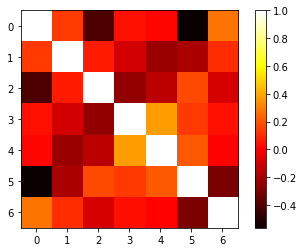

In [11]:
# Create correlation matrix
corr_mat = np.corrcoef(X, rowvar=False)

# Generate a heatmap of the correlation matrix
plt.imshow(corr_mat, cmap='hot')

# Plots colourbar as seen on right hand side
plt.colorbar() 

plt.show()

* Plotted and visualised a correlation matrix of the features.

### Splitting data into train and test and sets then scaling the data.

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [13]:
# Scale the data with respect to the training data set
scaler = StandardScaler()
scaler.fit(X_train)

# Scaling the Train data set using the transform defined by the train set.
X_scaled_train = pd.DataFrame(scaler.transform(X_train))

# Scaling the Test set using the transform defined by the train set.
X_scaled_test = pd.DataFrame(scaler.transform(X_test))

### Scaled data output

In [14]:
X_scaled_train.head()

,0,1,2,3,4,5,6
0,0.936067,-1.316976,-0.399713,-0.544679,3.247592,-0.306064,-1.897011
1,0.936067,0.759315,0.047743,-0.544679,-0.521181,-0.511883,0.563498
2,0.936067,0.759315,-0.606231,-0.544679,-0.521181,-0.511883,0.563498
3,-0.248576,0.759315,-0.743910,-0.544679,-0.521181,-0.466894,0.563498
4,0.936067,0.759315,-0.468552,-0.544679,-0.521181,-0.515479,0.563498


### Confusion Matrix for Binary Classification

* For each classifier below, we want to visualise our results. For a binary classification problem this can be done with a confusion matrix. The matrix below represents the predicted vs the actual results.

    - Bottom Left:       Number of people _incorrectly_ predicted to survive 
    - Bottom Right:      Number of people correctly predicted to not survive
    - Top Left:          Number of people correctly predicted to survive 
    - Top Right:         Number of people _incorrectly_ predicted to not survive 

In [15]:
def plot_confusion_matrix(cm, normalize = False):
    print(cm)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()
    tick_marks = np.arange(2)
    labels = ['Survived', 'Not Survived']
    
    plt.xticks(tick_marks, labels, rotation = 45)
    plt.yticks(tick_marks, labels)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if cm[i, j] > 0:
            plt.text(j, i, format(cm[i, j], fmt),
                    horizontalalignment="center",
                    color="white" if cm[i, j] > thresh else "black")
    
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.grid()
    plt.show(block = True)

* Ensure data is adequately shuffled to ensure a good random mix of test and train data. 

In [16]:
shuffle_validator = ShuffleSplit(n_splits=20, test_size=0.2, random_state=0)

def test_classifier(clf):
    """Given a calssifier, this method will generate an accuracy percent and confusion matrix"""
    scores =  cross_val_score(clf, X, y, cv=shuffle_validator)
    print("Final Accuracy: %0.4f (+/- %0.2f)" % (scores.mean(), scores.std()))
    y_pred = clf.predict(X=X_test)
    acc = metrics.accuracy_score(y_test, y_pred)
    
    y_pred_proba = clf.predict_proba(X_test)[::,1]
    fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
    
    plt.plot(fpr, tpr, label="Survival Rate")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc=4)
    plt.plot([0,1],[0,1],linestyle = "dashed", color = "orangered",linewidth = 1.5)
    plt.show()

    cm = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(cm, normalize=False)

### Decision Tree Classifier 

Training Score:  0.9328537170263789
Testing Score:  0.7607655502392344
Final Accuracy: 0.7737 (+/- 0.02)


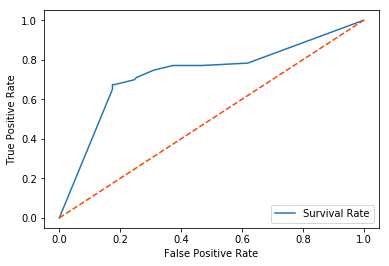

[[103  23]
 [ 27  56]]


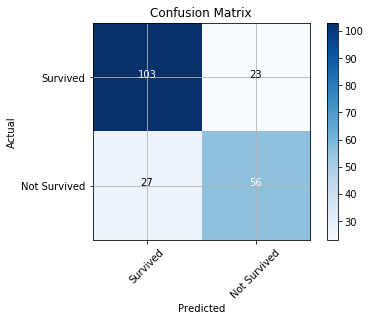

In [17]:
clf_dt = tree.DecisionTreeClassifier(max_depth=10)
clf_dt.fit(X_train, y_train)

train_score = clf_dt.score (X_train, y_train)
test_score = clf_dt.score (X_test, y_test)

print("Training Score: ", train_score)
print("Testing Score: ", test_score)

test_classifier(clf_dt)

### Random Forest Classifier 

Training Score:  0.9808153477218226
Testing Score:  0.7703349282296651
Final Accuracy: 0.7837 (+/- 0.02)


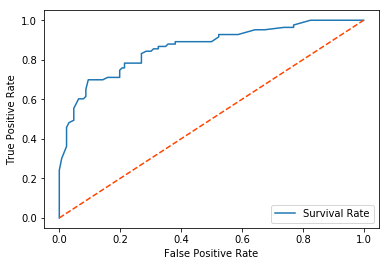

[[102  24]
 [ 24  59]]


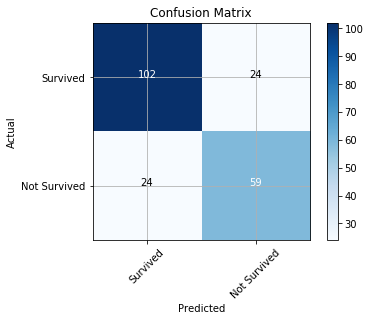

In [18]:
clf_rf = ske.RandomForestClassifier(n_estimators=50)
clf_rf.fit(X_train, y_train)

train_score = clf_rf.score (X_train, y_train)
test_score = clf_rf.score (X_test, y_test)

print("Training Score: ", train_score)
print("Testing Score: ", test_score)

test_classifier(clf_rf)

### Gradient Boosting Classifier 

Training Score:  0.8573141486810552
Testing Score:  0.8229665071770335
Final Accuracy: 0.8201 (+/- 0.02)


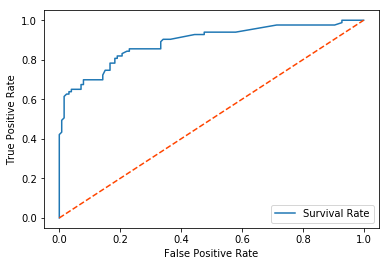

[[114  12]
 [ 25  58]]


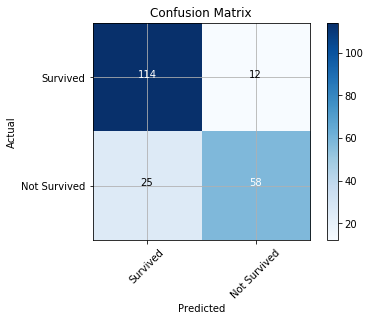

In [19]:
clf_gb = ske.GradientBoostingClassifier(n_estimators=50)
clf_gb.fit (X_train, y_train)

train_score = clf_gb.score (X_train, y_train)
test_score = clf_gb.score (X_test, y_test)

print("Training Score: ", train_score)
print("Testing Score: ", test_score)

test_classifier(clf_gb)

### Perceptron 

Training Score:  0.6306954436450839
Testing Score: 
 0.6363636363636364
Final Accuracy: 0.5828 (+/- 0.10)
[[62 64]
 [12 71]]


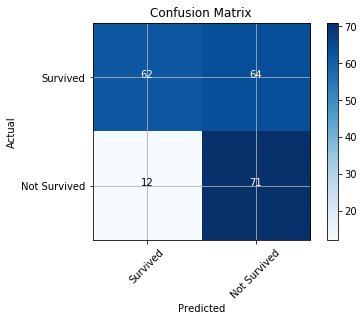

In [20]:
clf_prtn = Perceptron(tol=0.01, random_state=1)
clf_prtn.fit (X_train, y_train)

train_score = clf_prtn.score (X_train, y_train)
test_score = clf_prtn.score (X_test, y_test)

print("Training Score: ", train_score)
print("Testing Score: \n", test_score)

scores =  cross_val_score(clf_prtn, X, y, cv =shuffle_validator)
y_pred = clf_prtn.predict(X=X_test)
print("Final Accuracy: %0.4f (+/- %0.2f)" % (scores.mean(), scores.std()))
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, normalize=False)

### Voting Classifier

* Finally by using a voting classifier and giving it all 4 classifiers I'm able to get an average cross validated accuracy score for my classifiers and this results in an accuracy of ~80% which matches up with the Gradient Boosting Classifier accuracy. 

In [21]:
eclf = ske.VotingClassifier([('dt', clf_dt), ('rf', clf_rf), ('gb', clf_gb), ('prtn', clf_prtn)])
scores =  cross_val_score(eclf, X, y, cv=shuffle_validator)
print("Accuracy: %0.4f (+/- %0.2f)" % (scores.mean(), scores.std()))

Accuracy: 0.8002 (+/- 0.02)


## Summary of Classifier Results

|  Classifier |  Accuracy |
|---|---|
|DecisionTreeClassifier|Accuracy: 0.7737 (+/- 0.02)|
|RandomForestClassifier|Accuracy: 0.7837 (+/- 0.02)|
|GradientBoostingClassifier|Accuracy: 0.8201 (+/- 0.02)|
|Perceptron|Accuracy: 0.5828 (+/- 0.10)|

* From the above table of classifiers we can see that using a `GradientBoosting` Classifier returns us the best accuary for our problem. The DecisionTree classifier and RandomForrest classifier both reported similarly good results but the perceptron did not perform as well.